<a href="https://colab.research.google.com/github/PlugInRichi/Aleph/blob/main/TensorFlow/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

from scipy.io import loadmat
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
print('Keys: ', train.keys())
print('Train dimensions: ', train['X'].shape, ' target: ', train['y'].shape)
print('Test dimensions: ', test['X'].shape, ' target: ', test['y'].shape)

Keys:  dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Train dimensions:  (32, 32, 3, 73257)  target:  (73257, 1)
Test dimensions:  (32, 32, 3, 26032)  target:  (26032, 1)


### Reorganize axis

In [ ]:
x_train = np.moveaxis(train['X'], 3, 0)
x_test = np.moveaxis(test['X'], 3, 0)
y_train = train['y'] - 1
y_test = test['y'] - 1

In [ ]:
indexes = np.random.randint(0, high=len(x_train), size=10)
train_sample = [x_train[i] for i in indexes]
target_sample = [ train['y'][i] for i in indexes]

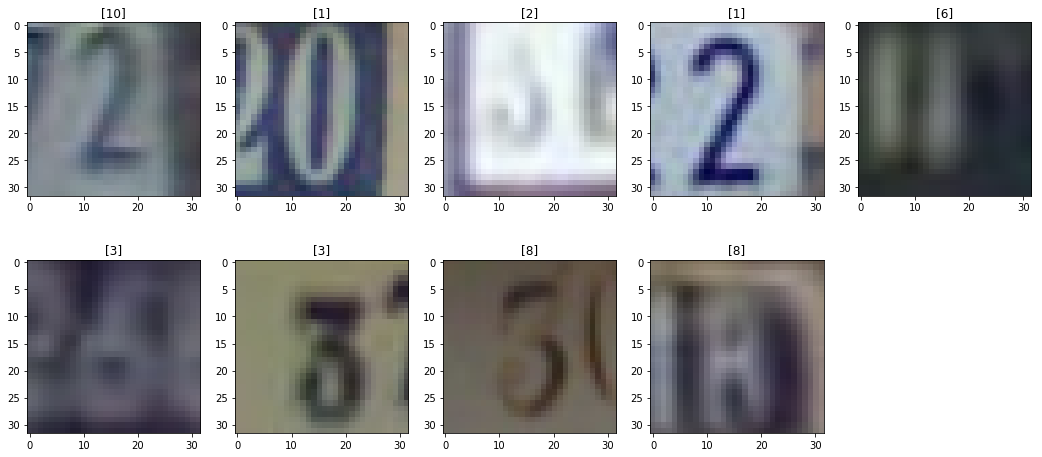

In [ ]:
fig = plt.figure(figsize=(18, 8))
for i in range(1, 10):
    fig.add_subplot(2, 5, i, title=str(target_sample[i]))
    plt.imshow(train_sample[i-1])
plt.show()

### Convert to gray scale

In [ ]:
x_train_gray = tf.image.rgb_to_grayscale(x_train) 
x_test_gray = tf.image.rgb_to_grayscale(x_test)

x_train_gray = tf.cast(x_train_gray, tf.float32) / 255.0
x_test_gray = tf.cast(x_test_gray, tf.float32) / 255.0

In [ ]:
indexes = np.random.randint(0, high=len(x_train_gray), size=10)
train_sample = [x_train_gray[i].numpy() for i in indexes]
target_sample = [train['y'][i] for i in indexes]

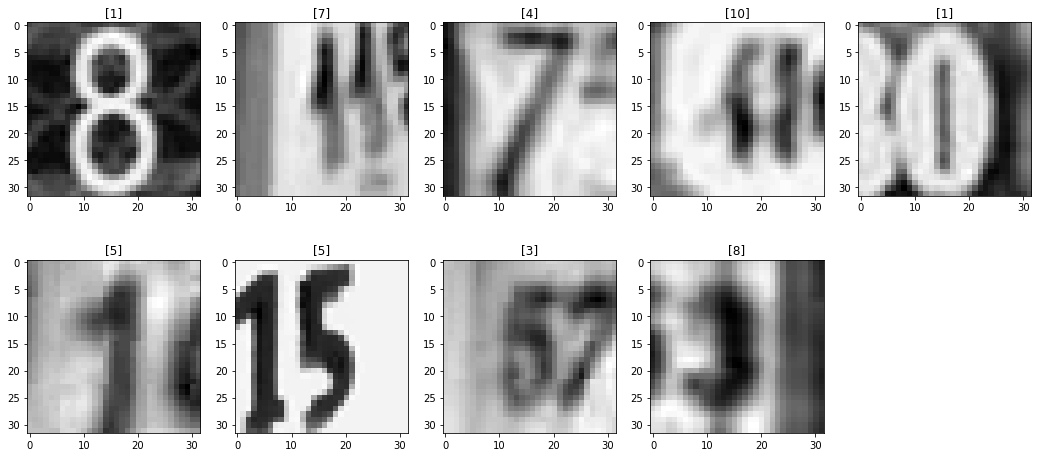

In [ ]:
fig = plt.figure(figsize=(18, 8))
for i in range(1, 10):
    fig.add_subplot(2, 5, i, title=str(target_sample[i]))
    plt.imshow(train_sample[i-1].reshape(32,32), cmap='gray')
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
model = Sequential([
    Flatten(input_shape=x_train_gray[0].shape),
    Dense(200, activation='tanh'), 
    Dense(300, activation='tanh'), 
    Dense(500, activation='tanh'), 
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               205000    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_6 (Dense)              (None, 500)               150500    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5010      
Total params: 420,810
Trainable params: 420,810
Non-trainable params: 0
_________________________________________________________________


### Callbacks

In [ ]:

lr = LearningRateScheduler(lambda epoch, lr : lr*0.7 if lr > 0.05 else lr)

ckpt = ModelCheckpoint('rich_modelx/ckpt-{val_acc}', 
                       save_best_only=True, 
                       save_weights_only=True)

### Compile

In [ ]:
model.compile(
    optimazer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['acc','mse'])

### Training

In [ ]:
history = model.fit(
            x_train_gray, 
            y_train,
            validation_split=0.20, 
            batch_size=64,
            epochs=20,
            callbacks=[lr, ckpt])

Train on 58605 samples, validate on 14652 samples
Epoch 1/20
58605/58605 [==============================] - 44s 746us/sample - loss: 2.1832 - acc: 0.2264 - mse: 19.9871 - val_loss: 1.6764 - val_acc: 0.4290 - val_mse: 19.8853
Epoch 2/20
58605/58605 [==============================] - 43s 737us/sample - loss: 1.5475 - acc: 0.4843 - mse: 20.0075 - val_loss: 1.4942 - val_acc: 0.5154 - val_mse: 19.9083
Epoch 3/20
58605/58605 [==============================] - 42s 713us/sample - loss: 1.2724 - acc: 0.5895 - mse: 20.0179 - val_loss: 1.3105 - val_acc: 0.5907 - val_mse: 19.9069
Epoch 4/20
58605/58605 [==============================] - 42s 715us/sample - loss: 1.1202 - acc: 0.6421 - mse: 20.0231 - val_loss: 1.2158 - val_acc: 0.6177 - val_mse: 19.9150
Epoch 5/20
58605/58605 [==============================] - 42s 711us/sample - loss: 1.0233 - acc: 0.6737 - mse: 20.0266 - val_loss: 0.9378 - val_acc: 0.7023 - val_mse: 19.9206
Epoch 6/20
58605/58605 [==============================] - 43s 727us/sample 

### Accuracy vs. epochs

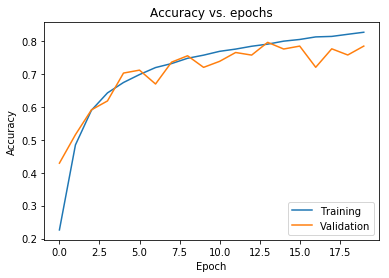

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

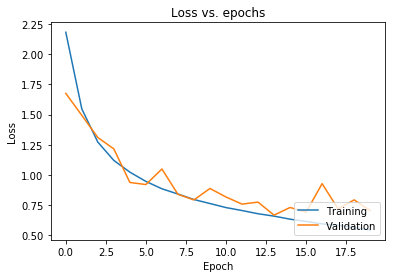

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

### Evaluation

In [ ]:
model.evaluate(x_test_gray, y_test, verbose = 0)

[0.7943607665639606, 0.7545713, 19.490423]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
model_CNN = Sequential([
    Conv2D(20, kernel_size=(7, 7), activation='relu', input_shape=x_train_gray[0].shape),
    MaxPool2D(pool_size=(3,3)),
    Conv2D(10, kernel_size=(5, 5), activation='relu'),
    MaxPool2D(pool_size=(3,3)),
    Flatten(),
    BatchNormalization(),
    Dense(200, activation='tanh'),
    Dropout(0.5),
    Dense(300, activation='tanh'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model_CNN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 20)        1000      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 10)          5010      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 10)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 10)                40        
_________________________________________________________________
dense_23 (Dense)             (None, 200)              

In [ ]:
model_CNN.compile(
    optimazer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['acc', 'mse'])

In [ ]:
ckpt = ModelCheckpoint('rich_model_CNN/ckpt-{val_acc}', 
                       save_weights_only=True)
es = EarlyStopping(monitor='val_acc', patience=2)

In [ ]:
history = model_CNN.fit(
            x_train_gray, 
            y_train,
            validation_split=0.20, 
            batch_size=32,
            epochs=15,
            callbacks=[lr, ckpt, es])

Train on 58605 samples, validate on 14652 samples
Epoch 1/15
58605/58605 [==============================] - 194s 3ms/sample - loss: 1.2065 - acc: 0.6000 - mse: 20.0164 - val_loss: 2.0326 - val_acc: 0.4606 - val_mse: 19.9252
Epoch 2/15
58605/58605 [==============================] - 191s 3ms/sample - loss: 0.9090 - acc: 0.7143 - mse: 20.0285 - val_loss: 1.1310 - val_acc: 0.6475 - val_mse: 19.9246
Epoch 3/15
58605/58605 [==============================] - 189s 3ms/sample - loss: 0.8319 - acc: 0.7392 - mse: 20.0317 - val_loss: 0.9267 - val_acc: 0.7076 - val_mse: 19.9250
Epoch 4/15
58605/58605 [==============================] - 189s 3ms/sample - loss: 0.7843 - acc: 0.7540 - mse: 20.0339 - val_loss: 0.7031 - val_acc: 0.7854 - val_mse: 19.9293
Epoch 5/15
58605/58605 [==============================] - 191s 3ms/sample - loss: 0.7620 - acc: 0.7643 - mse: 20.0351 - val_loss: 0.6989 - val_acc: 0.7836 - val_mse: 19.9279
Epoch 6/15
58605/58605 [==============================] - 193s 3ms/sample - loss

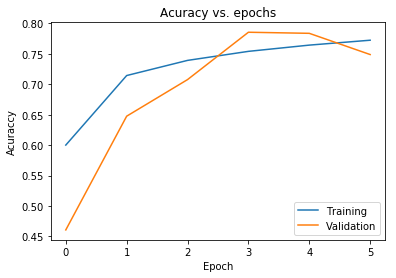

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Acuracy vs. epochs')
plt.ylabel('Acuraccy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

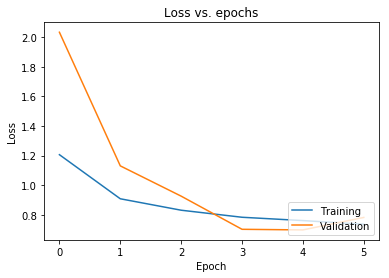

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [ ]:
model_CNN.evaluate(x_test_gray, y_test, verbose = 0)

[0.8142628489862429, 0.7387446, 19.485626]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [ ]:
path = tf.train.latest_checkpoint('rich_modelx/')
model.load_weights(path)

In [ ]:
path = tf.train.latest_checkpoint('rich_model_CNN/')
model_CNN.load_weights(path)

### Get indexes for predict

In [ ]:
indexes = np.random.randint(0, high=len(x_test), size=5)
test_sample = [x_test[i] for i in indexes]
test_sample_g = [x_test_gray[i].numpy() for i in indexes]
target_sample = [test['y'][i] for i in indexes]

# CNN

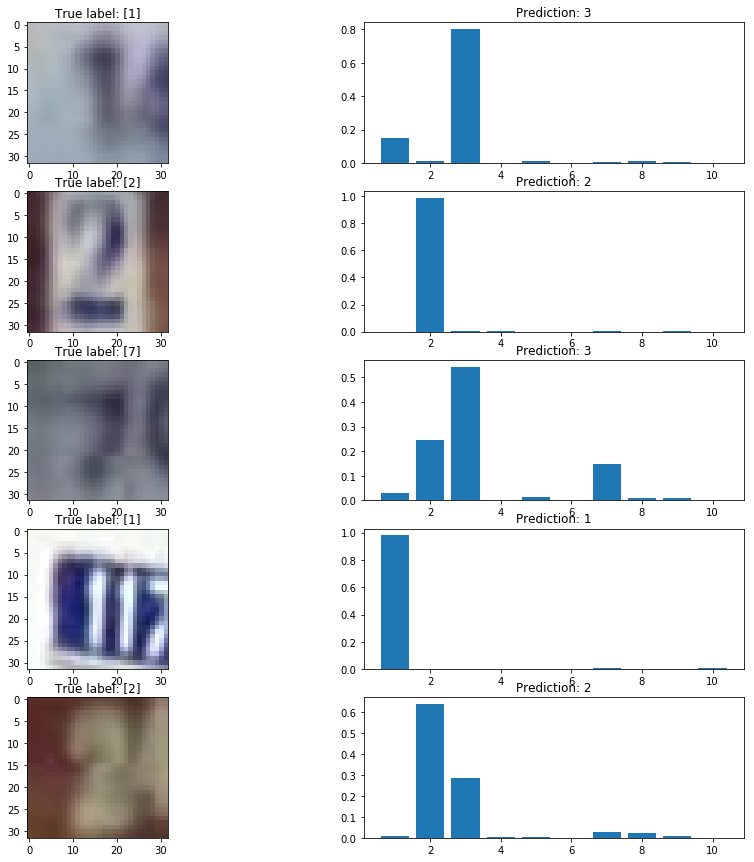

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i in range(0, 5):
    #Plot_image
    fig.add_subplot(5, 2, i*2+1, title='True label: '+str(target_sample[i-1]))
    plt.imshow(test_sample[i-1])
    #Plot_hist
    predicc = model_CNN.predict(np.expand_dims(test_sample_g[i-1], axis=0))
    index = list(predicc[0]).index(max(predicc[0]))
    fig.add_subplot(5, 2, i*2+2, title='Prediction: '+str(index+1))
    plt.bar(range(1,11),predicc[0])
plt.show()

# MLP

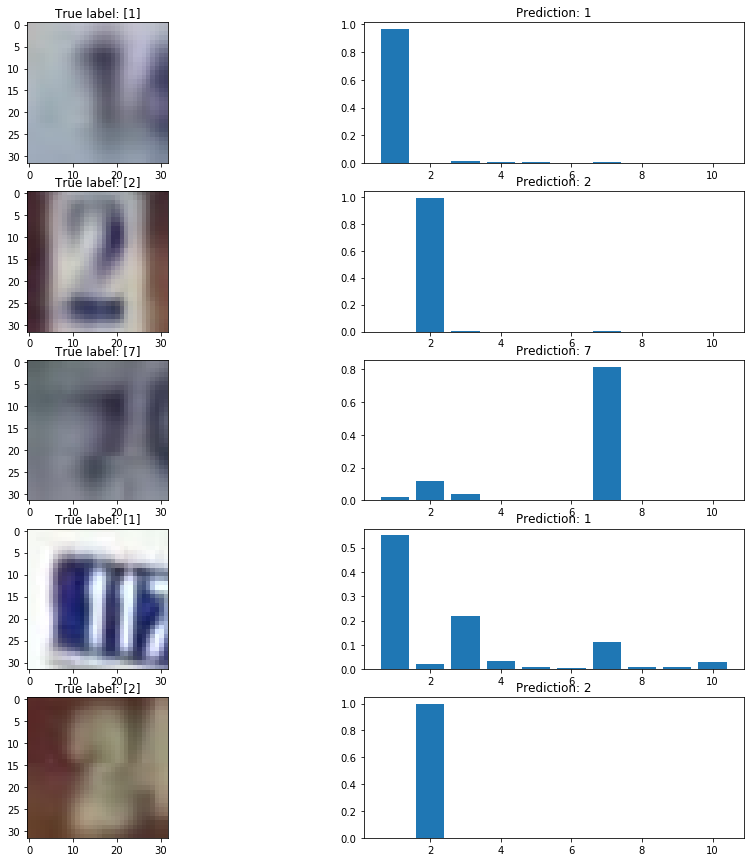

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i in range(0, 5):
    #Plot_image
    fig.add_subplot(5, 2, i*2+1, title='True label: '+str(target_sample[i-1]))
    plt.imshow(test_sample[i-1])
    #Plot_hist
    predicc = model.predict(np.expand_dims(test_sample_g[i-1], axis=0))
    index = list(predicc[0]).index(max(predicc[0]))
    fig.add_subplot(5, 2, i*2+2, title='Prediction: '+str(index+1))
    plt.bar(range(1,11),predicc[0])
plt.show()